In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
train_dir = '/content/gdrive/MyDrive/anh/train'
validation_dir = '/content/gdrive/MyDrive/anh/validation'
train_human_dir = '/content/gdrive/MyDrive/anh/train/human'
train_non_human_dir = '/content/gdrive/MyDrive/anh/train/non_human'
validation_human_dir = '/content/gdrive/MyDrive/anh/validation/human'
validation_non_human_dir = '/content/gdrive/MyDrive/anh/validation/non_human'

num_human_train = len(os.listdir(train_human_dir))
num_non_human_train = len(os.listdir(train_non_human_dir))
num_human_val =  len(os.listdir(validation_human_dir))
num_non_human_val = len(os.listdir(validation_non_human_dir))

total_train = num_human_train + num_non_human_train
total_val = num_human_val + num_non_human_val
print('number of humans train', num_human_train)
print('number of non humans train', num_non_human_train)
print('number of humans validation', num_human_val)
print('number of non humans validation', num_non_human_val)

number of humans train 1000
number of non humans train 1000
number of humans validation 500
number of non humans validation 500


In [ ]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator      = ImageDataGenerator(rescale= 1./255,                                
                                                horizontal_flip=True,
                                                rotation_range = 40,
                                                zoom_range = 0.2)  # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(directory= train_dir, 
                                                           target_size= (IMG_SHAPE,IMG_SHAPE), 
                                                           shuffle = True)
validation_image_generator = ImageDataGenerator(rescale= 1./255)  
val_data_gen = validation_image_generator.flow_from_directory(directory= validation_dir,
                                                              target_size= (IMG_SHAPE,IMG_SHAPE),
                                                              shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation
from keras.layers import Flatten, Input, Dropout, concatenate
from keras.regularizers import  l2
from keras import backend as K
from keras.models import Model
from tensorflow.keras.optimizers import SGD

class Inceptionv1_builder():

    def __init__(self, input_shape = (224,224,3), output_units = 2, init_kernel = (7,7), init_strides = (2,2), init_filters = 64,
                 regularizer = l2(1e-4), initializer = "he_normal", init_maxpooling = True):
        '''
        :param input_shape: input shape of dataset
        :param output_units: output result dimension
        :param init_kernel: The kernel size for first convolution layer
        :param init_strides: The strides for first convolution layer
        :param init_filters: The filter number for first convolution layer
        :param regularizer: regularizer for all the convolution layers in whole NN
        :param initializer: weight/parameters initializer for all convolution & fc layers in whole NN
        :param init_maxpooling: Do the maxpooling after first two convolution layers or not
        '''

        assert len(input_shape) == 3, "input shape should be dim 3 ( row, col, channel or channel row col )"

        self.input_shape = input_shape
        self.output_units = output_units
        self.init_kernel = init_kernel
        self.init_strides = init_strides
        self.init_filters = init_filters
        self.regularizer = regularizer
        self.initializer = initializer
        self.init_maxpooling = init_maxpooling

    def _cn_relu(self, filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same"):
        '''
        convenient function to build convolution(with regularizer and initializer) -> relu activation layers
        '''
        def f(input_x):

            x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,activation="relu",
                       kernel_initializer = self.initializer , kernel_regularizer = self.regularizer)(input_x)
            return x

        return f

    def _auxiliary(self, name = "auxiliary_1"):
        '''
        In author's explanation:
        " The auxiliary classifier will encourage discrimination in lower stages in the classifier,
        increase the gradient signal that gets propagated back, and provide additional regularization"
        :return: An output layer of auxiliary classifier
        '''
        def f(input_x):

            x = input_x
            x = AveragePooling2D(pool_size=(5,5), strides = (3,3), padding = "same")(x)
            x = self._cn_relu(filters = 128, kernel_size = (1,1), padding = "same")(x)
            x = Flatten()(x)
            x = Dense(units = 1024, activation = "relu", kernel_regularizer= self.regularizer)(x)
            x = Dropout(0.7)(x)

            return Dense(units = self.output_units, activation = "softmax", kernel_initializer=self.initializer, name = name)(x)

        return f


    def _inception_block(self, _1x1 = 64, _3x3r = 96, _3x3 = 128, _5x5r = 16, _5x5 = 32, _maxpool = 32, name = "inception3a"):
        '''
        A function for building inception block, including 1x1 convolution layer, 3x3 convolution layer with dimension reducing,
        5x5 convolution layer with dimension reducing and maxpooling layer with dimension reducing
        :param _1x1: filter number of 1x1 convolution layer
        :param _3x3r: filter number of dimension reducing layer for 3x3 convolution layer
        :param _3x3: filter number of 3x3 convolution layer
        :param _5x5r: filter number of dimension reducing layer for 5x5 convolution layer
        :param _5x5: filter number of 5x5 convolution layer
        :param _maxpool: filter number of dimension reducing layer for maxpooling layer
        :return: A concatenate block of several scale convolution which is inception block
        '''
        def f(input_x):

            branch1x1 = self._cn_relu(filters=_1x1, kernel_size=(1, 1), strides=(1, 1), padding="same")(input_x)

            branch3x3 = self._cn_relu(filters=_3x3r, kernel_size=(1, 1), strides=(1, 1), padding="same")(input_x)
            branch3x3 = self._cn_relu(filters=_3x3, kernel_size=(3, 3), strides=(1, 1), padding="same")(branch3x3)

            branch5x5 = self._cn_relu(filters=_5x5r, kernel_size=(1, 1), strides=(1, 1), padding="same")(input_x)
            branch5x5 = self._cn_relu(filters=_5x5, kernel_size=(5, 5), strides=(1, 1), padding="same",)(branch5x5)

            brancemaxpool = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding = "same")(input_x)
            brancemaxpool = self._cn_relu(filters=_maxpool, kernel_size=(1, 1), strides=(1, 1), padding="same")(brancemaxpool)

            return concatenate([branch1x1,branch3x3,branch5x5,brancemaxpool], axis = 3 , name = name)

        return f
    def build_inception(self):

        '''
        Main function for building inceptionV1 nn
        :return: An inceptionV1 nn
        '''

        #Few traditional convolutional layers at lower layers
        input_x = Input(self.input_shape)

        x = self._cn_relu(filters = self.init_filters, kernel_size = self.init_kernel, strides = self.init_strides, padding = "same")(input_x)

        if self.init_maxpooling:
            x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "same")(x)

        x = self._cn_relu(filters = 192, kernel_size = (3,3), strides = (1, 1), padding = "same")(x)

        if self.init_maxpooling:
            x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "same")(x)

        #inception(3a)
        x = self._inception_block(_1x1=64, _3x3r=96, _3x3=128, _5x5r=16, _5x5=32, _maxpool=32, name = "inception3a")(x)

        #inception(3b)
        x = self._inception_block(_1x1=128, _3x3r=128, _3x3=192, _5x5r=32, _5x5=96, _maxpool=64, name = "inception3b")(x)

        x = MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(x)

        #inception(4a)
        x = self._inception_block(_1x1=192, _3x3r=96, _3x3=208, _5x5r=16, _5x5=48, _maxpool=64, name = "inception4a")(x)

        #auxiliary classifier 1
        auxiliary1 = self._auxiliary(name = "auxiliary_1")(x)

        # inception(4b)
        x = self._inception_block(_1x1=160, _3x3r=112, _3x3=224, _5x5r=24, _5x5=64, _maxpool=64, name = "inception4b")(x)
        # inception(4c)
        x = self._inception_block(_1x1=128, _3x3r=128, _3x3=256, _5x5r=24, _5x5=64, _maxpool=64, name = "inception4c")(x)
        # inception(4d)
        x = self._inception_block(_1x1=112, _3x3r=144, _3x3=288, _5x5r=32, _5x5=64, _maxpool=64, name = "inception4d")(x)

        #auxiliary classifier 2
        auxiliary2 = self._auxiliary(name = "auxiliary_2")(x)

        # inception(4e)
        x = self._inception_block(_1x1=256, _3x3r=160, _3x3=320, _5x5r=32, _5x5=128, _maxpool=128, name = "inception4e")(x)

        x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding = "same")(x)

        #inception(5a)
        x = self._inception_block(_1x1=256, _3x3r=160, _3x3=320, _5x5r=32, _5x5=128, _maxpool=128, name = "inception5a")(x)
        #inception(5b)
        x = self._inception_block(_1x1=384, _3x3r=192, _3x3=384, _5x5r=48, _5x5=128, _maxpool=128, name = "inception5b")(x)

        x_shape = K.int_shape(x)
        x = AveragePooling2D(pool_size = (x_shape[1], x_shape[2]), strides=(1,1))(x)
        x = Flatten()(x)
        x = Dropout(0.4)(x)
        #x = Dense(units = 1024, kernel_initializer = self.initializer, activation="relu")(x)
        output_x = Dense(units = self.output_units, activation = "softmax", kernel_initializer=self.initializer, name = "main_output")(x)

        inceptionv1_model = Model(inputs = [input_x], outputs = [auxiliary1, auxiliary2, output_x])

        return inceptionv1_model


inception_builder = Inceptionv1_builder()
model = inception_builder.build_inception()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 192)  110784      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf
import numpy as np
model.compile(
    optimizer = SGD(learning_rate= 0.0001, momentum=0.9),
    loss = ['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
    metrics=['accuracy']
)

In [ ]:
epochs = 80

history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= total_val // BATCH_SIZE
)

Epoch 1/80
20/20 [==============================] - 317s 14s/step - loss: 4.5107 - auxiliary_1_loss: 0.9981 - auxiliary_2_loss: 0.9159 - main_output_loss: 0.7934 - auxiliary_1_accuracy: 0.5547 - auxiliary_2_accuracy: 0.5156 - main_output_accuracy: 0.5375 - val_loss: 3.8830 - val_auxiliary_1_loss: 0.7049 - val_auxiliary_2_loss: 0.7980 - val_main_output_loss: 0.5770 - val_auxiliary_1_accuracy: 0.4000 - val_auxiliary_2_accuracy: 0.0906 - val_main_output_accuracy: 1.0000
Epoch 2/80
20/20 [==============================] - 117s 6s/step - loss: 4.1359 - auxiliary_1_loss: 0.8062 - auxiliary_2_loss: 0.7562 - main_output_loss: 0.7704 - auxiliary_1_accuracy: 0.5369 - auxiliary_2_accuracy: 0.4936 - main_output_accuracy: 0.5080 - val_loss: 4.0402 - val_auxiliary_1_loss: 0.7145 - val_auxiliary_2_loss: 0.8003 - val_main_output_loss: 0.7223 - val_auxiliary_1_accuracy: 0.4031 - val_auxiliary_2_accuracy: 0.0156 - val_main_output_accuracy: 0.0500
Epoch 3/80
20/20 [==============================] - 89s 4

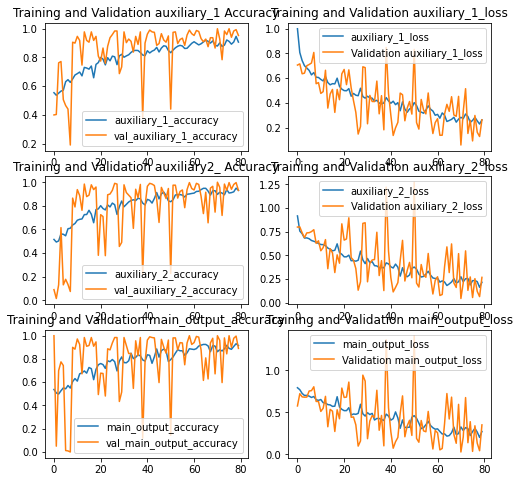

In [ ]:
import matplotlib.pyplot as plt



epochs_range = range(epochs)

auxiliary_1_accuracy= history.history['auxiliary_1_accuracy']
val_auxiliary_1_accuracy = history.history['val_auxiliary_1_accuracy']

auxiliary_1_loss = history.history['auxiliary_1_loss']
val_auxiliary_1_loss = history.history['val_auxiliary_1_loss']

auxiliary_2_accuracy= history.history['auxiliary_2_accuracy']
val_auxiliary_2_accuracy = history.history['val_auxiliary_2_accuracy']

auxiliary_2_loss = history.history['auxiliary_2_loss']
val_auxiliary_2_loss = history.history['val_auxiliary_2_loss']

main_output_accuracy= history.history['main_output_accuracy']
val_main_output_accuracy = history.history['val_main_output_accuracy']

main_output_loss = history.history['main_output_loss']
val_main_output_loss = history.history['val_main_output_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, auxiliary_1_accuracy, label='auxiliary_1_accuracy')
plt.plot(epochs_range, val_auxiliary_1_accuracy, label='val_auxiliary_1_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation auxiliary_1 Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, auxiliary_1_loss, label='auxiliary_1_loss')
plt.plot(epochs_range, val_auxiliary_1_loss, label='Validation auxiliary_1_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation auxiliary_1_loss')

plt.subplot(3, 2, 3)
plt.plot(epochs_range, auxiliary_2_accuracy, label='auxiliary_2_accuracy')
plt.plot(epochs_range, val_auxiliary_2_accuracy, label='val_auxiliary_2_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation auxiliary2_ Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, auxiliary_2_loss, label='auxiliary_2_loss')
plt.plot(epochs_range, val_auxiliary_2_loss, label='Validation auxiliary_2_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation auxiliary_2_loss')

plt.subplot(3, 2, 5)
plt.plot(epochs_range, main_output_accuracy, label='main_output_accuracy')
plt.plot(epochs_range, val_main_output_accuracy, label='val_main_output_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation main_output_accuracy')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, main_output_loss, label='main_output_loss')
plt.plot(epochs_range, val_main_output_loss, label='Validation main_output_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation main_output_loss')

plt.show()